<a href="https://colab.research.google.com/github/rahul-proximity/Flux-Experiments/blob/main/Copy_of_flux_lora_quant_blogpost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optionally mount to google drive to save results

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

FOLDERNAME = 'flux_lora_quant' # path to folder
assert FOLDERNAME is not None, "[!] Enter the foldername."

folder_path = '/content/drive/My Drive/{}'.format(FOLDERNAME)

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/flux_lora_quant


# Fine-Tuning FLUX.1-dev on consumer hardware and in FP8

In our previous post, [Exploring Quantization Backends in Diffusers](https://huggingface.co/blog/diffusers-quantization), we dived into how various quantization techniques can shrink diffusion models like FLUX.1-dev, making them significantly more accessible for *inference* without drastically compromising performance. We saw how `bitsandbytes`, `torchao`, and others reduce memory footprints for generating images.

Performing inference is cool but to make these models truly our own, we also need to be able to fine-tune them. Therefore, in this post, we tackle **efficient** *fine-tuning* of these models with peak memory use under ~10 GB of VRAM on a single GPU. This post will guide you through fine-tuning FLUX.1-dev using QLoRA with the Hugging Face `diffusers` library. We'll showcase results from an NVIDIA RTX 4090. We'll also highlight how FP8 training with `torchao` can further optimize speed on compatible hardware.

This Colab notebook provides all the code necessary to run the training and inference process described in the blog post (But, has been slightly modified so that it is able to run on T4 GPU in a reasonable amount of time)

### Setup

First, let's install the required libraries.

In [ ]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.7.13 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [ ]:
!uv pip install -q diffusers accelerate bitsandbytes wandb datasets==2.19.0

Logging in to the Hugging Face Hub is required as black-forest-labs/FLUX.1-dev is gated and to push your trained LoRA adapter to the Hub at the end

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

You can optionally log into wandb if you want to report to wandb

In [ ]:
!wandb login

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


## Dataset

We aim to fine-tune `black-forest-labs/FLUX.1-dev` to adopt the artistic style of Alphonse Mucha, using a small [dataset](https://huggingface.co/datasets/derekl35/alphonse-mucha-style).

## FLUX Architecture

The model consists of three main components:

  * **Text Encoders (CLIP and T5)**
  * **Transformer (Main Model - MMDiT)**
  * **Variational Auto-Encoder (VAE)**

In our QLoRA approach, we focus exclusively on fine-tuning the **transformer component** (MMDiT). The text encoders and VAE remain frozen throughout training.

## QLoRA Fine-tuning FLUX.1-dev with `diffusers`

We will use a `diffusers` training script  (modified from https://github.com/huggingface/diffusers/tree/main/examples/research_projects/flux_lora_quantization) designed for DreamBooth-style LoRA fine-tuning of FLUX models. Before we can train, we need to pre-compute the text embeddings for our dataset. This is a one-time step that saves VRAM during training, as we won't need to keep the large text encoders in memory.

### Step 1: Pre-computing Text Embeddings

The following cell loads the text encoders from FLUX.1-dev, processes each image caption in our dataset, and saves the resulting text embeddings to a `.parquet` file. This file will be loaded by the training script.

In [ ]:
import pandas as pd
import torch
from datasets import load_dataset
from huggingface_hub.utils import insecure_hashlib
from tqdm.auto import tqdm
from transformers import T5EncoderModel

from diffusers import FluxPipeline


MAX_SEQ_LENGTH = 77
OUTPUT_PATH = "embeddings_alphonse_mucha.parquet"
DATASET_NAME = "derekl35/alphonse-mucha-style"
MODEL_ID = "black-forest-labs/FLUX.1-dev"

def generate_image_hash(image):
    return insecure_hashlib.sha256(image.tobytes()).hexdigest()


def load_flux_dev_pipeline():
    id = "black-forest-labs/FLUX.1-dev"
    text_encoder = T5EncoderModel.from_pretrained(id, subfolder="text_encoder_2", load_in_8bit=True, device_map="auto")
    pipeline = FluxPipeline.from_pretrained(
        id, text_encoder_2=text_encoder, transformer=None, vae=None, device_map="balanced"
    )
    return pipeline


@torch.no_grad()
def compute_embeddings(pipeline, prompts, max_sequence_length):
    all_prompt_embeds = []
    all_pooled_prompt_embeds = []
    all_text_ids = []
    for prompt in tqdm(prompts, desc="Encoding prompts."):
        (
            prompt_embeds,
            pooled_prompt_embeds,
            text_ids,
        ) = pipeline.encode_prompt(prompt=prompt, prompt_2=None, max_sequence_length=max_sequence_length)
        all_prompt_embeds.append(prompt_embeds)
        all_pooled_prompt_embeds.append(pooled_prompt_embeds)
        all_text_ids.append(text_ids)

    max_memory = torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024
    print(f"Max memory allocated: {max_memory:.3f} GB")
    return all_prompt_embeds, all_pooled_prompt_embeds, all_text_ids


def run():
    dataset = load_dataset(DATASET_NAME, split="train")
    image_prompts = {generate_image_hash(sample["image"]): sample["text"] for sample in dataset}
    all_prompts = list(image_prompts.values())
    print(f"{len(all_prompts)=}")

    pipeline = load_flux_dev_pipeline()
    all_prompt_embeds, all_pooled_prompt_embeds, all_text_ids = compute_embeddings(
        pipeline, all_prompts, MAX_SEQ_LENGTH
    )

    data = []
    for i, (image_hash, _) in enumerate(image_prompts.items()):
        data.append((image_hash, all_prompt_embeds[i], all_pooled_prompt_embeds[i], all_text_ids[i]))
    print(f"{len(data)=}")

    # Create a DataFrame
    embedding_cols = ["prompt_embeds", "pooled_prompt_embeds", "text_ids"]
    df = pd.DataFrame(data, columns=["image_hash"] + embedding_cols)
    print(f"{len(df)=}")

    # Convert embedding lists to arrays (for proper storage in parquet)
    for col in embedding_cols:
        df[col] = df[col].apply(lambda x: x.cpu().numpy().flatten().tolist())

    # Save the dataframe to a parquet file
    df.to_parquet(OUTPUT_PATH)
    print(f"Data successfully serialized to {OUTPUT_PATH}")

    del pipeline
    del dataset
    del image_prompts
    del all_prompts
    del all_prompt_embeds
    del all_pooled_prompt_embeds
    del all_text_ids
    del df
    torch.cuda.empty_cache()


run()

Generating train split:   0%|          | 0/13 [00:00<?, ? examples/s]

len(all_prompts)=13


config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Encoding prompts.:   0%|          | 0/13 [00:00<?, ?it/s]

Max memory allocated: 7.867 GB
len(data)=13
len(df)=13
Data successfully serialized to embeddings_alphonse_mucha.parquet


### Key Optimization Techniques

**LoRA (Low-Rank Adaptation) Deep Dive:** [LoRA](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora) makes model training more efficient by keeping track of the weight updates with low-rank matrices. Instead of updating the full weight matrix $$W$$, LoRA learns two smaller matrices $$A$$ and $$B$$. The update to the weights for the model is $$\Delta W = B A$$, where $$A \in \mathbb{R}^{r \times k}$$ and $$B \in \mathbb{R}^{d \times r}$$. The number $$r$$ (called _rank_) is much smaller than the original dimensions, which means less parameters to update. Lastly, $$\alpha$$ is a scaling factor for the LoRA activations. This affects how much LoRA affects the updates, and is often set to the same value as the $$r$$ or a multiple of it. It helps balance the influence of the pre-trained model and the LoRA adapter. For a general introduction to the concept, check out our previous blog post: [Using LoRA for Efficient Stable Diffusion Fine-Tuning](https://huggingface.co/blog/lora).

<p align="center">
  <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png"
       alt="Illustration of LoRA injecting two low-rank matrices around a frozen weight matrix"
       width="600"/>
</p>

**QLoRA: The Efficiency Powerhouse:** [QLoRA](https://huggingface.co/docs/peft/main/en/developer_guides/quantization) enhances LoRA by first loading the pre-trained base model in a quantized format (typically 4-bit via `bitsandbytes`), drastically cutting the base model's memory footprint. It then trains LoRA adapters (usually in FP16/BF16) on top of this quantized base. This dramatically lowers the VRAM needed to hold the base model.

For instance, in the [DreamBooth training script for HiDream](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README_hidream.md#using-quantization) 4-bit quantization with bitsandbytes reduces the peak memory usage of a LoRA fine-tune from ~60GB down to ~37GB. The very same principle is what we apply here to fine-tune FLUX.1 on consumer-grade hardware.

**8-bit Optimizer (AdamW):**
Standard AdamW optimizer maintains first and second moment estimates for each parameter in 32-bit (FP32), which consumes a lot of memory. The 8-bit AdamW uses block-wise quantization to store optimizer states in 8-bit precision, while maintaining training stability. This technique can reduce optimizer memory usage by ~75% compared to standard FP32 AdamW. Enabling it in the script is straightforward:

```python

# Check for the --use_8bit_adam flag
if args.use_8bit_adam:
    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

optimizer = optimizer_class(
    params_to_optimize,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)
```

**Gradient Checkpointing:**
During forward pass, intermediate activations are typically stored for backward pass gradient computation. Gradient checkpointing trades computation for memory by only storing certain _checkpoint activations_ and recomputing others during backpropagation.

```python
if args.gradient_checkpointing:
    transformer.enable_gradient_checkpointing()
```

**Cache Latents:**
This optimization technique pre-processes all training images through the VAE encoder before the beginning of the training. It stores the resulting latent representations in memory. During the training, instead of encoding images on-the-fly, the cached latents are directly used. This approach offers two main benefits:
1. eliminates redundant VAE encoding computations during training, speeding up each training step
2. allows the VAE to be completely removed from GPU memory after caching. The trade-off is increased RAM usage to store all cached latents, but this is typically manageable for small datasets.

```python
# Cache latents before training if the flag is set
    if args.cache_latents:
        latents_cache = []
        for batch in tqdm(train_dataloader, desc="Caching latents"):
            with torch.no_grad():
                batch["pixel_values"] = batch["pixel_values"].to(
                    accelerator.device, non_blocking=True, dtype=weight_dtype
                )
                latents_cache.append(vae.encode(batch["pixel_values"]).latent_dist)
        # VAE is no longer needed, free up its memory
        del vae
        free_memory()
```

### Step 2: Training the QLoRA Adapter

Now we can run the main training script. We've adapted it to run directly in this notebook. It will load the 4-bit quantized `FLUX.1-dev` model, add LoRA adapters to its transformer block, and fine-tune it on the Alphonse Mucha dataset using the embeddings we just created.

**Note:** The original blog post used 700 training steps, which took \~41 minutes on an 4090 and would take several hours on a T4. For a quicker demonstration in this notebook, we've reduced `max_train_steps` to 200. You can increase this value for higher-quality results (but you might hit usage limits, if using [original script](https://github.com/huggingface/diffusers/tree/main/examples/research_projects/flux_lora_quantization) you can train for 350 steps and save a checkpoint and once usage limits reset you can *resume* from the checkpoint and train another 350 steps).

In [ ]:
import copy
import logging
import math
import os
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import torch
import transformers
from accelerate import Accelerator, DistributedType
from accelerate.logging import get_logger
from accelerate.utils import DistributedDataParallelKwargs, ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub.utils import insecure_hashlib
from peft import LoraConfig, prepare_model_for_kbit_training, set_peft_model_state_dict
from peft.utils import get_peft_model_state_dict
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms.functional import crop
from tqdm.auto import tqdm

import diffusers
from diffusers import (
    AutoencoderKL, BitsAndBytesConfig, FlowMatchEulerDiscreteScheduler,
    FluxPipeline, FluxTransformer2DModel,
)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import (
    cast_training_params, compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3, free_memory,
)
from diffusers.utils import convert_unet_state_dict_to_peft, is_wandb_available
from diffusers.utils.torch_utils import is_compiled_module

logger = get_logger(__name__)

class DreamBoothDataset(Dataset):
    def __init__(self, data_df_path, dataset_name, width, height, max_sequence_length=77):
        self.width, self.height, self.max_sequence_length = width, height, max_sequence_length
        self.data_df_path = Path(data_df_path)
        if not self.data_df_path.exists():
            raise ValueError("`data_df_path` doesn't exists.")

        dataset = load_dataset(dataset_name, split="train")
        self.instance_images = [sample["image"] for sample in dataset]
        self.image_hashes = [insecure_hashlib.sha256(img.tobytes()).hexdigest() for img in self.instance_images]
        self.pixel_values = self._apply_transforms()
        self.data_dict = self._map_embeddings()
        self._length = len(self.instance_images)

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        idx = index % len(self.instance_images)
        hash_key = self.image_hashes[idx]
        prompt_embeds, pooled_prompt_embeds, text_ids = self.data_dict[hash_key]
        return {
            "instance_images": self.pixel_values[idx],
            "prompt_embeds": prompt_embeds,
            "pooled_prompt_embeds": pooled_prompt_embeds,
            "text_ids": text_ids,
        }

    def _apply_transforms(self):
        transform = transforms.Compose([
            transforms.Resize((self.height, self.width), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomCrop((self.height, self.width)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

        pixel_values = []
        for image in self.instance_images:
            image = exif_transpose(image).convert("RGB") if image.mode != "RGB" else exif_transpose(image)
            pixel_values.append(transform(image))
        return pixel_values

    def _map_embeddings(self):
        df = pd.read_parquet(self.data_df_path)
        data_dict = {}
        for _, row in df.iterrows():
            prompt_embeds = torch.from_numpy(np.array(row["prompt_embeds"]).reshape(self.max_sequence_length, 4096))
            pooled_prompt_embeds = torch.from_numpy(np.array(row["pooled_prompt_embeds"]).reshape(768))
            text_ids = torch.from_numpy(np.array(row["text_ids"]).reshape(77, 3))
            data_dict[row["image_hash"]] = (prompt_embeds, pooled_prompt_embeds, text_ids)
        return data_dict

def collate_fn(examples):
    pixel_values = torch.stack([ex["instance_images"] for ex in examples]).float()
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    prompt_embeds = torch.stack([ex["prompt_embeds"] for ex in examples])
    pooled_prompt_embeds = torch.stack([ex["pooled_prompt_embeds"] for ex in examples])
    text_ids = torch.stack([ex["text_ids"] for ex in examples])[0]

    return {
        "pixel_values": pixel_values,
        "prompt_embeds": prompt_embeds,
        "pooled_prompt_embeds": pooled_prompt_embeds,
        "text_ids": text_ids,
    }

def main(args):
    # Setup accelerator
    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=ProjectConfiguration(project_dir=args.output_dir, logging_dir=Path(args.output_dir, "logs")),
        kwargs_handlers=[DistributedDataParallelKwargs(find_unused_parameters=True)],
    )

    # Setup logging
    logging.basicConfig(format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", level=logging.INFO)
    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    set_seed(args.seed) if args.seed is not None else None
    os.makedirs(args.output_dir, exist_ok=True) if accelerator.is_main_process else None

    # Load models with quantization
    noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
    noise_scheduler_copy = copy.deepcopy(noise_scheduler)

    vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae")

    nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)
    transformer = FluxTransformer2DModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="transformer",
        quantization_config=nf4_config, torch_dtype=torch.float16
    )
    transformer = prepare_model_for_kbit_training(transformer, use_gradient_checkpointing=False)

    # Freeze models and setup LoRA
    transformer.requires_grad_(False)
    vae.requires_grad_(False)
    vae.to(accelerator.device, dtype=torch.float16)
    if args.gradient_checkpointing:
        transformer.enable_gradient_checkpointing()

    # now we will add new LoRA weights to the attention layers
    transformer_lora_config = LoraConfig(
        r=args.rank,
        lora_alpha=args.rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    transformer.add_adapter(transformer_lora_config)

    print(f"trainable params: {transformer.num_parameters(only_trainable=True)} || all params: {transformer.num_parameters()}")

    # Setup optimizer
    import bitsandbytes as bnb
    optimizer = bnb.optim.AdamW8bit(
        [{"params": list(filter(lambda p: p.requires_grad, transformer.parameters())), "lr": args.learning_rate}],
        betas=(0.9, 0.999), weight_decay=1e-04, eps=1e-08
    )

    # Setup dataset and dataloader
    train_dataset = DreamBoothDataset(args.data_df_path, "derekl35/alphonse-mucha-style", args.width, args.height)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    # Cache latents
    vae_config = vae.config
    latents_cache = []
    for batch in tqdm(train_dataloader, desc="Caching latents"):
        with torch.no_grad():
            pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.float16)
            latents_cache.append(vae.encode(pixel_values).latent_dist)

    del vae
    free_memory()

    # Setup scheduler and training steps
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    args.max_train_steps = args.max_train_steps or args.num_train_epochs * num_update_steps_per_epoch

    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    lr_scheduler = get_scheduler("constant", optimizer=optimizer, num_warmup_steps=0, num_training_steps=args.max_train_steps)

    # Prepare for training
    transformer, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(transformer, optimizer, train_dataloader, lr_scheduler)

    # Register save/load hooks
    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        return model._orig_mod if is_compiled_module(model) else model

    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            for model in models:
                if isinstance(unwrap_model(model), type(unwrap_model(transformer))):
                    lora_layers = get_peft_model_state_dict(unwrap_model(model))
                    FluxPipeline.save_lora_weights(output_dir, transformer_lora_layers=lora_layers, text_encoder_lora_layers=None)
                    weights.pop() if weights else None

    accelerator.register_save_state_pre_hook(save_model_hook)
    cast_training_params([transformer], dtype=torch.float32) if args.mixed_precision == "fp16" else None

    # Initialize tracking
    accelerator.init_trackers("dreambooth-flux-dev-lora-alphonse-mucha", config=vars(args)) if accelerator.is_main_process else None

    # Training loop
    def get_sigmas(timesteps, n_dim=4, dtype=torch.float32):
        sigmas = noise_scheduler_copy.sigmas.to(device=accelerator.device, dtype=dtype)
        schedule_timesteps = noise_scheduler_copy.timesteps.to(accelerator.device)
        step_indices = [(schedule_timesteps == t).nonzero().item() for t in timesteps.to(accelerator.device)]
        sigma = sigmas[step_indices].flatten()
        while len(sigma.shape) < n_dim:
            sigma = sigma.unsqueeze(-1)
        return sigma

    global_step = 0
    progress_bar = tqdm(range(args.max_train_steps), desc="Steps", disable=not accelerator.is_local_main_process)

    for epoch in range(args.num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate([transformer]):
                # Get cached latents
                model_input = latents_cache[step].sample()
                model_input = (model_input - vae_config.shift_factor) * vae_config.scaling_factor
                model_input = model_input.to(dtype=torch.float16)

                # Prepare inputs
                latent_image_ids = FluxPipeline._prepare_latent_image_ids(
                    model_input.shape[0], model_input.shape[2] // 2, model_input.shape[3] // 2,
                    accelerator.device, torch.float16
                )

                noise = torch.randn_like(model_input)
                bsz = model_input.shape[0]

                u = compute_density_for_timestep_sampling("none", bsz, 0.0, 1.0, 1.29)
                indices = (u * noise_scheduler_copy.config.num_train_timesteps).long()
                timesteps = noise_scheduler_copy.timesteps[indices].to(device=model_input.device)

                sigmas = get_sigmas(timesteps, n_dim=model_input.ndim, dtype=model_input.dtype)
                noisy_model_input = (1.0 - sigmas) * model_input + sigmas * noise

                packed_noisy_model_input = FluxPipeline._pack_latents(
                    noisy_model_input, model_input.shape[0], model_input.shape[1],
                    model_input.shape[2], model_input.shape[3]
                )

                # Forward pass
                guidance = torch.tensor([args.guidance_scale], device=accelerator.device).expand(bsz) if unwrap_model(transformer).config.guidance_embeds else None

                model_pred = transformer(
                    hidden_states=packed_noisy_model_input,
                    timestep=timesteps / 1000,
                    guidance=guidance,
                    pooled_projections=batch["pooled_prompt_embeds"].to(accelerator.device, dtype=torch.float16),
                    encoder_hidden_states=batch["prompt_embeds"].to(accelerator.device, dtype=torch.float16),
                    txt_ids=batch["text_ids"].to(accelerator.device, dtype=torch.float16),
                    img_ids=latent_image_ids,
                    return_dict=False,
                )[0]

                vae_scale_factor = 2 ** (len(vae_config.block_out_channels) - 1)
                model_pred = FluxPipeline._unpack_latents(
                    model_pred, model_input.shape[2] * vae_scale_factor,
                    model_input.shape[3] * vae_scale_factor, vae_scale_factor
                )

                # Compute loss
                weighting = compute_loss_weighting_for_sd3("none", sigmas)
                target = noise - model_input
                loss = torch.mean((weighting.float() * (model_pred.float() - target.float()) ** 2).reshape(target.shape[0], -1), 1).mean()

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(transformer.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                # Checkpointing
                if global_step % args.checkpointing_steps == 0 and (accelerator.is_main_process or accelerator.distributed_type == DistributedType.DEEPSPEED):
                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)

            # Logging
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break

    # Final save
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        transformer_lora_layers = get_peft_model_state_dict(unwrap_model(transformer))
        FluxPipeline.save_lora_weights(args.output_dir, transformer_lora_layers=transformer_lora_layers, text_encoder_lora_layers=None)

    if torch.cuda.is_available():
        print(f"Pipeline memory usage: {torch.cuda.max_memory_reserved() / 1024**3:.3f} GB")
    else:
        print("Training completed. GPU not available for memory tracking.")

    accelerator.end_training()

if __name__ == "__main__":
    class Args:
        pretrained_model_name_or_path = "black-forest-labs/FLUX.1-dev"
        data_df_path = "embeddings_alphonse_mucha.parquet"
        output_dir = "alphonse_mucha_lora_flux_nf4"
        mixed_precision = "fp16"
        weighting_scheme = "none"
        width, height = 512, 768
        train_batch_size = 1
        learning_rate = 1e-4
        guidance_scale = 1.0
        report_to = "wandb"
        gradient_accumulation_steps = 4
        gradient_checkpointing = True
        rank = 4
        max_train_steps = 100
        seed = 0
        checkpointing_steps = 100

    main(Args())
    # clear memory
    # del transformer
    torch.cuda.empty_cache()

{'time_shift_type', 'use_karras_sigmas', 'invert_sigmas', 'shift_terminal', 'use_exponential_sigmas', 'use_beta_sigmas'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initialized from the model checkpoint at black-forest-labs/FLUX.1-dev.
If your task is similar to the task the model of the checkpoint was trained on, you can already use AutoencoderKL for predictions without further training.
The device_map was not initialized. Setting device_map to {: {current_device}}. If you want to use the model for inference, please set device_map ='auto' 


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Instantiating FluxTransformer2DModel model under default dtype torch.float16.
{'out_channels', 'axes_dims_rope'} was not found in config. Values will be initialized to default values.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing FluxTransformer2DModel.

All the weights of FluxTransformer2DModel were initialized from the model checkpoint at black-forest-labs/FLUX.1-dev.
If your task is similar to the task the model of the checkpoint was trained on, you can already use FluxTransformer2DModel for predictions without further training.


trainable params: 4669440 || all params: 11906077760


Caching latents:   0%|          | 0/13 [00:00<?, ?it/s]

wandb: Currently logged in as: derekliu2021 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-100/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-200/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-300/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-400/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-500/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-600/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/checkpoint-700/pytorch_lora_weights.safetensors
Model weights saved in alphonse_mucha_lora_flux_nf4/pytorch_lora_weights.safetensors


Pipeline memory usage: 8.385 GB


loss,▂▄▂▅▆▇▁▅▂▆▃▅▃▅▃▅▁▄█▃▄▃▅▄▅▄▅▂▇▄▃▁▅▅▆▆▅▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.5993
lr,0.0001


**Training Results:**

On a free-tier T4 GPU in Colab, the QLoRA fine-tuning process with these settings used approximately 9.8 GB of VRAM. With `max_train_steps=100`, training took about 30 minutes. The full 700 steps from the blog post would take around 4 hours.

The (700 steps) fine-tuned model nicely captured Mucha's iconic art nouveau style, evident in the decorative motifs and distinct color palette. The QLoRA process maintained excellent fidelity while learning the new style.

base model (bf16):
![base model bf16 outputs](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/quantization-backends-diffusers2/alphonse_mucha_base_bf16_combined.png)

<details>
<summary>base model (fp16)</summary>

![base model outputs](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/quantization-backends-diffusers2/alphonse_mucha_base_combined.png)

</details>

QLoRA fine-tuned (mixed_precision=bf16):

![QLoRA model outputs](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/quantization-backends-diffusers2/alphonse_mucha_merged_qlora_bf16_combined.png)

<details>
<summary>qlora (mixed_precision=fp16)</summary>

![QLoRA model outputs](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/quantization-backends-diffusers2/alphonse_mucha_merged_combined.png)

</details>

*Prompts: (left to right)*

*Serene raven-haired woman, moonlit lilies, swirling botanicals, alphonse mucha style*

*a puppy in a pond, alphonse mucha style*

*Ornate fox with a collar of autumn leaves and berries, amidst a tapestry of forest foliage, alphonse mucha style*

The fine-tuned model nicely captured Mucha's iconic art nouveau style, evident in the decorative motifs and distinct color palette. The QLoRA process maintained excellent fidelity while learning the new style.


## FP8 Fine-tuning with `torchao`

For users with NVIDIA GPUs possessing compute capability 8.9 or greater (such as the H100), even greater speed efficiencies can be achieved by leveraging FP8 training via the `torchao` library.

**Note:** The following code requires compute capability \>= 8.9 (e.g. NVIDIA H100/H200)

```bash
accelerate launch train_dreambooth_lora_flux.py \
  --pretrained_model_name_or_path=black-forest-labs/FLUX.1-dev \
  --dataset_name=derekl35/alphonse-mucha-style --instance_prompt="a woman, alphonse mucha style" --caption_column="text" \
  --output_dir=alphonse_mucha_fp8_lora_flux \
  --mixed_precision=bf16 --use_8bit_adam \
  --weighting_scheme=none \
  --height=768 --width=512 --train_batch_size=1 --repeats=1 \
  --learning_rate=1e-4 --guidance_scale=1 --report_to=wandb \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --lr_scheduler=constant --lr_warmup_steps=0 --rank=4 \
  --max_train_steps=700 --checkpointing_steps=600 --seed=0 \
  --do_fp8_training --push_to_hub
```

The training run on an H100 had a **peak memory usage of 36.57 GB** and completed in approximately **20 minutes**.

Qualitative results from this FP8 fine-tuned model are also available:
![FP8 model outputs](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/quantization-backends-diffusers2/alphonse_mucha_fp8_combined.png)

Key steps to enable FP8 training with `torchao` involve:

1.  **Injecting FP8 layers** into the model using `convert_to_float8_training` from `torchao.float8`.
2.  **Defining a `module_filter_fn`** to specify which modules should and should not be converted to FP8.

For a more detailed guide and code snippets, please refer to [this gist](https://gist.github.com/sayakpaul/f0358dd4f4bcedf14211eba5704df25a) and the [`diffusers-torchao` repository](https://www.google.com/search?q=%5Bhttps://github.com/sayakpaul/diffusers-torchao/tree/main/training%5D\(https://github.com/sayakpaul/diffusers-torchao/tree/main/training\)).

## Inference with Trained LoRA Adapters

After training your LoRA adapters, you have two main approaches for inference.

### Option 1: Loading LoRA Adapters

One approach is to [load your trained LoRA adapters](https://huggingface.co/docs/diffusers/v0.33.1/en/using-diffusers/loading_adapters#lora) on top of the base model. This is flexible and allows you to easily switch between different styles. We also quantize the model to fit RAM or VRAM of free tier of google colab

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/28 [00:00<?, ?it/s]

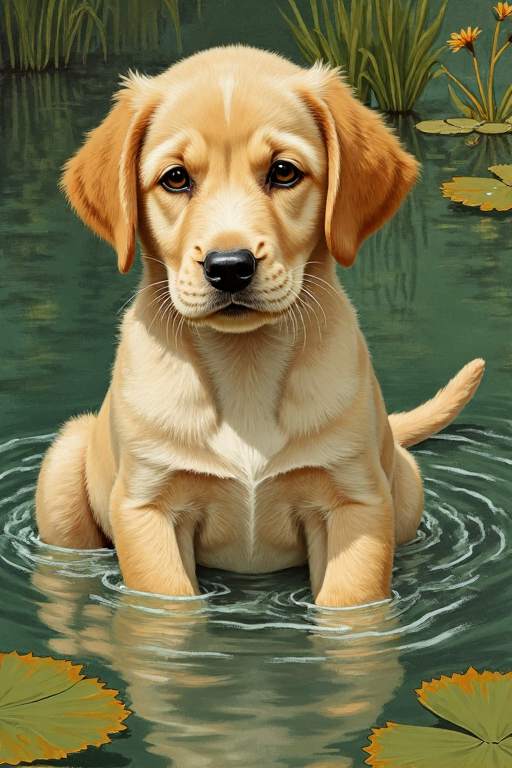

In [ ]:
from diffusers import FluxPipeline, AutoPipelineForText2Image, FluxTransformer2DModel, BitsAndBytesConfig
from transformers import T5EncoderModel
from transformers import BitsAndBytesConfig as TransformersBitsAndBytesConfig
import torch
import gc

ckpt_id = "black-forest-labs/FLUX.1-dev"
lora_path = "alphonse_mucha_lora_flux_nf4"
fused_transformer_path = "fused_transformer"

bnb_4bit_compute_dtype = torch.float16

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
)

# Load pipeline and fuse LoRA
transformer = FluxTransformer2DModel.from_pretrained(
    ckpt_id, subfolder="transformer",
    quantization_config=nf4_config, torch_dtype=torch.float16
)

quant_config = TransformersBitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

text_encoder = T5EncoderModel.from_pretrained(ckpt_id, subfolder="text_encoder_2", quantization_config=quant_config, torch_dtype=torch.float16,)

pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    transformer=transformer,
    text_encoder_2=text_encoder,
    torch_dtype=bnb_4bit_compute_dtype,
)
pipeline.load_lora_weights(lora_path)

del text_encoder
del transformer
gc.collect()
torch.cuda.empty_cache()

pipeline.to("cuda")

prompt = "a puppy in a pond, alphonse mucha style"
image = pipeline(
    prompt,
    num_inference_steps=28,
    guidance_scale=3.5,
    height=768,
    width=512,
    generator=torch.manual_seed(0)
).images[0]

print(f"Pipeline memory usage: {torch.cuda.max_memory_reserved() / 1024**3:.3f} GB")

image.save("alphonse_mucha_lora.png")
image

### Option 2: Merging LoRA into Base Model

For when you want maximum efficiency with a single style, you can [merge the LoRA weights](https://huggingface.co/docs/diffusers/using-diffusers/merge_loras) into the base model. This can make inference slightly faster and allows you to re-quantize the merged model. It is [recommended](https://github.com/huggingface/diffusers/tree/main/examples/research_projects/flux_lora_quantization#inference) to first dequantize the base model, merge the LoRA params into it, and then quantize the model again.

But, google colab free tier does not have enough RAM, so we will directly merge the lora weights into quantized model. Notice that merging lora weights into quantized model has less of the style, as the rounding removes the affect of the LoRA.

The device_map was not initialized. Setting device_map to {: {current_device}}. If you want to use the model for inference, please set device_map ='auto' 


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Instantiating FluxTransformer2DModel model under default dtype torch.float16.
{'out_channels', 'axes_dims_rope'} was not found in config. Values will be initialized to default values.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing FluxTransformer2DModel.

All the weights of FluxTransformer2DModel were initialized from the model checkpoint at black-forest-labs/FLUX.1-dev.
If your task is similar to the task the model of the checkpoint was trained on, you can already use FluxTransformer2DModel for predictions without further training.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{'feature_extractor', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Instantiating AutoencoderKL model under default dtype torch.float16.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initialized from the model checkpoint at /root/.cache/huggingface/hub/models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/vae.
If your task is similar to the task the model of the checkpoint was trained on, you can already use AutoencoderKL for predictions without further training.
Loaded vae as AutoencoderKL from `vae` subfolder of black-forest-labs/FLUX.1-dev.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of black-forest-labs/FLUX.1-dev.
Loaded tokenizer_2 as T5TokenizerFast from `tokenizer_2` subfolder of black-forest-labs/FLUX.1-dev.
{'time_shift_type', 'use_karras_sigmas', 'invert_sigmas', 'shift_terminal', 'use_exponential_sigmas', 'use_beta_sigmas'} was not found in config. Values will be initialized to default values.
Loaded scheduler as FlowMatchEul

  0%|          | 0/28 [00:00<?, ?it/s]

Pipeline memory usage: 33.209 GB


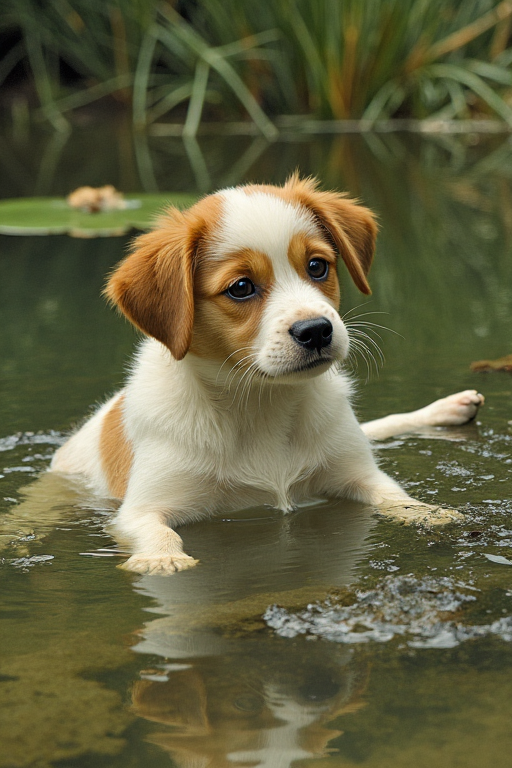

In [ ]:
from diffusers import FluxPipeline, AutoPipelineForText2Image, FluxTransformer2DModel, BitsAndBytesConfig
from transformers import T5EncoderModel
from transformers import BitsAndBytesConfig as TransformersBitsAndBytesConfig
import torch
import gc

ckpt_id = "black-forest-labs/FLUX.1-dev"
lora_path = "alphonse_mucha_lora_flux_nf4"
fused_transformer_path = "fused_transformer"

bnb_4bit_compute_dtype = torch.float16

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
)

# Load pipeline and fuse LoRA
transformer = FluxTransformer2DModel.from_pretrained(
    ckpt_id, subfolder="transformer",
    quantization_config=nf4_config, torch_dtype=torch.float16
)

quant_config = TransformersBitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

text_encoder = T5EncoderModel.from_pretrained(ckpt_id, subfolder="text_encoder_2", quantization_config=quant_config, torch_dtype=torch.float16,)

pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    transformer=transformer,
    text_encoder_2=text_encoder,
    torch_dtype=bnb_4bit_compute_dtype,
)
pipeline.load_lora_weights(lora_path)
pipeline.fuse_lora()
pipeline.unload_lora_weights()

del text_encoder
del transformer
gc.collect()
torch.cuda.empty_cache()

pipeline.to("cuda")

prompt = "a puppy in a pond, alphonse mucha style"
image = pipeline(
    prompt,
    num_inference_steps=28,
    guidance_scale=3.5,
    height=768,
    width=512,
    generator=torch.manual_seed(0)
).images[0]

print(f"Pipeline memory usage: {torch.cuda.max_memory_reserved() / 1024**3:.3f} GB")

image.save("alphonse_mucha_merged.png")
image

## Conclusion

QLoRA, coupled with the `diffusers` library, significantly democratizes the ability to customize state-of-the-art models like FLUX.1-dev. As demonstrated on an RTX 4090, efficient fine-tuning is well within reach, yielding high-quality stylistic adaptations. Furthermore, for users with the latest NVIDIA hardware, `torchao` enables even faster training through FP8 precision.

### Share your creations on the Hub\!

Sharing your fine-tuned LoRA adapters is a fantastic way to contribute to the open-source community. It allows others to easily try out your styles, build on your work, and helps create a vibrant ecosystem of creative AI tools.

If you've trained a LoRA for FLUX.1-dev, we encourage you to [share](https://huggingface.co/docs/transformers/en/model_sharing) it. The easiest way is to add the --push\_to\_hub flag to the training script. Alternatively, if you have already trained a model and want to upload it, you can use the following snippet.

In [ ]:
# Prereqs:
# - pip install huggingface_hub diffusers
# - Run `huggingface-cli login` (or set HF_TOKEN env-var) once.
# - save model

from huggingface_hub import create_repo, upload_folder

# Make sure you are logged in with `notebook_login()` first
repo_id = "your-username/alphonse_mucha_qlora_flux" # Change "your-username"
create_repo(repo_id, exist_ok=True)

upload_folder(
    repo_id=repo_id,
    folder_path="alphonse_mucha_lora_flux_nf4",
    commit_message="Add Alphonse Mucha QLoRA adapter"
)

Check out our Mucha QLoRA https://huggingface.co/derekl35/alphonse_mucha_qlora_flux FP8 LoRA https://huggingface.co/derekl35/alphonse_mucha_fp8_lora_flux. You can find both, plus other adapters, in [this collection](https://huggingface.co/collections/derekl35/flux-qlora-68527afe2c0ca7bc82a6d8d9) as an example.

We can't wait to see what you create!